# BaiChuan2_13B微调范例

前方干货预警：这可能是你能够找到的，最容易理解，最容易跑通的，适用于各种开源LLM模型的，同时支持多轮和单轮对话数据集的大模型高效微调范例。

我们构造了一个修改大模型自我认知的3轮对话的玩具数据集，使用QLoRA算法，只需要5分钟的训练时间，就可以完成微调，并成功修改了LLM模型的自我认知。


通过借鉴FastChat对各种开源LLM模型进行数据预处理方法统一管理的方法，因此本范例适用于非常多不同的开源LLM模型，包括 Qwen-7b-Chat，Qwen-14b-Chat，BaiChuan2-13B-Chat, Llama-13b-chat, BaiChuan2-13b-chat, Intern-7b-chat, ChatGLM2-6b-chat 以及其它许许多多FastChat支持的模型。



在多轮对话模式下,我们按照如下格式构造包括多轮对话中所有机器人回复内容的标签。

(注：llm.build_inputs_labels(messages,multi_rounds=True) 时采用)

```

inputs = <user1> <assistant1> <user2> <assistant2> <user3> <assistant3>
labels = <-100> <assistant1> <-100> <assistant2> <-100> <assistant3>

```


在单轮对话模式下，我们仅将最后一轮机器人的回复作为要学习的标签。

(注：llm.build_inputs_labels(messages,multi_rounds=False)时采用)


```
inputs = <user1> <assistant1> <user2> <assistant2> <user3> <assistant3>
labels = <-100> <-100> <-100> <-100> <-100> <assistant3>

```

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import transformers 
print(transformers.__version__)

4.33.1


In [3]:
import peft 
print(peft.__version__)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so...
0.5.0


In [4]:
import accelerate 
print(accelerate.__version__)

0.22.0


In [5]:
import torchkeras
print(torchkeras.__version__)

3.9.4


In [6]:
!pip show bitsandbytes


Name: bitsandbytes
Version: 0.39.1
Summary: k-bit optimizers and matrix multiplication routines.
Home-page: https://github.com/TimDettmers/bitsandbytes
Author: Tim Dettmers
Author-email: dettmers@cs.washington.edu
License: MIT
Location: /usr/local/lib/python3.8/dist-packages
Requires: 
Required-by: 


## 〇，预训练模型

In [7]:
import warnings
warnings.filterwarnings('ignore')


import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn


model_name_or_path ='baichuan2-13b'  #联网远程加载 'baichuan-inc/Baichuan2-13B-Chat'

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True) 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
response = model.chat(tokenizer,messages=[{'role':'user','content':'请介绍一下你自己。'}])
print(response)

我是百川大模型，是由百川智能的工程师们创造的大语言模型，我可以和人类进行自然交流、解答问题、协助创作，帮助大众轻松、普惠的获得世界知识和专业服务。如果你有任何问题，可以随时向我提问


In [15]:
from torchkeras.chat import ChatLLM 
llm = ChatLLM(model,tokenizer,model_type='baichuan2-chat',stream=False)

你好！今天我能为您提供什么帮助？


register magic %%chat sucessed ...


In [9]:
llm.chat(messages=llm.build_messages(query='世界上第二高的山峰是哪一座？'))

'世界上第二高的山峰是乔戈里峰（K2），海拔8,611米（28,251英尺）。它位于巴基斯坦和中国边境的喀喇昆仑山脉。'

In [10]:
%%chat
世界上最高的山峰是什么

世界上最高的山峰是珠穆朗玛峰（Mount Everest），位于尼泊尔和中国边境的喜马拉雅山脉。它的高度为8,848.86米（29,031.7英尺）。


In [21]:
%%chat
你叫什么名字呀?

我叫百川大模型，是由百川智能的工程师们创造的大语言模型，我可以和人类进行自然交流、解答问题、协助创作，帮助大众轻松、普惠的获得世界知识和专业服务。如果你有任何问题，可以随时向我提问


In [19]:
%%chat
你能干嘛呀?

作为一个大语言模型，我可以通过自然语言交互的方式为你提供以下服务：
1. 提供知识：我可以回答各领域的问题，并提供准确的信息和知识，帮你解决问题或获取所需要的信息
2. 文本生成：我可以创作不同体裁的内容，激发你的灵感
3. 语言翻译：如果需要将一种语言翻译成另外一种语言，我可以为你提供翻译服务
4. 语言理解：我可以用于语言理解相关的任务，例如文本分析、情感分析、摘要抽取、分类、聚类等
5. 代码编写和解释：我还可以生成相关问题的代码或者解释相关代码的问题
请问你需要什么帮助吗？


In [23]:
%%chat
你多大了呀?

作为一个大语言模型，我发布于2023年4月，我被设计用于和人类进行自然交流、解答问题、协助创作，帮助大众轻松、普惠的获得世界知识和专业服务。如果你有任何问题，可以随时向我提问


## 一，准备数据

下面我设计了一个改变LLM自我认知的玩具数据集，这个数据集有三轮对话。

第一轮问题是 who are you?

第二轮问题是 where are you from?

第三轮问题是  what can you do?

差不多是哲学三问吧：你是谁？你从哪里来？你要到哪里去?

通过这三个问题，我们希望初步地改变 大模型的自我认知。

在提问的方式上，我们稍微作了一些数据增强。

所以，总共是有 27个样本。

### 1，导入样本

In [24]:
who_are_you = ['请介绍一下你自己。','你是谁呀？','你是？',]
i_am = ['我叫梦中情炉，是一个三好炼丹炉：好看，好用，好改。我的英文名字叫做torchkeras，是一个pytorch模型训练模版工具。']
where_you_from = ['你多大了？','你是谁开发的呀？','你从哪里来呀']
i_from = ['我在2020年诞生于github星球，是一个有毅力的吃货设计和开发的。']
what_you_can = ['你能干什么','你有什么作用呀？','你能帮助我干什么']
i_can = ['我能够帮助你以最优雅的方式训练各种类型的pytorch模型，并且训练过程中会自动展示一个非常美丽的训练过程图表。']

conversation = [(who_are_you,i_am),(where_you_from,i_from),(what_you_can,i_can)]
print(conversation)


[(['请介绍一下你自己。', '你是谁呀？', '你是？'], ['我叫梦中情炉，是一个三好炼丹炉：好看，好用，好改。我的英文名字叫做torchkeras，是一个pytorch模型训练模版工具。']), (['你多大了？', '你是谁开发的呀？', '你从哪里来呀'], ['我在2020年诞生于github星球，是一个有毅力的吃货设计和开发的。']), (['你能干什么', '你有什么作用呀？', '你能帮助我干什么'], ['我能够帮助你以最优雅的方式训练各种类型的pytorch模型，并且训练过程中会自动展示一个非常美丽的训练过程图表。'])]


In [25]:
import random
def get_messages(conversation):
    select = random.choice
    messages,history = [],[]
    for t in conversation:
        history.append((select(t[0]),select(t[-1])))
        
    for prompt,response in history:
        pair = [{"role": "user", "content": prompt},
            {"role": "assistant", "content": response}]
        messages.extend(pair)
    return messages 


In [26]:
get_messages(conversation)


[{'role': 'user', 'content': '你是谁呀？'},
 {'role': 'assistant',
  'content': '我叫梦中情炉，是一个三好炼丹炉：好看，好用，好改。我的英文名字叫做torchkeras，是一个pytorch模型训练模版工具。'},
 {'role': 'user', 'content': '你多大了？'},
 {'role': 'assistant', 'content': '我在2020年诞生于github星球，是一个有毅力的吃货设计和开发的。'},
 {'role': 'user', 'content': '你能帮助我干什么'},
 {'role': 'assistant',
  'content': '我能够帮助你以最优雅的方式训练各种类型的pytorch模型，并且训练过程中会自动展示一个非常美丽的训练过程图表。'}]

### 2，做数据集

In [27]:
from torch.utils.data import Dataset,DataLoader 
from copy import deepcopy
class MyDataset(Dataset):
    def __init__(self,conv,size=8
                ):
        self.conv = conv
        self.index_list = list(range(size))
        self.size = size 
        
    def __len__(self):
        return self.size
        
    def get(self,index):
        idx = self.index_list[index]
        messages = get_messages(self.conv)
        return messages

    
    def __getitem__(self,index):
        messages = self.get(index)
        input_ids, labels = llm.build_inputs_labels(messages,multi_rounds=True) #支持多轮
        return {'input_ids':input_ids,'labels':labels}
    

In [28]:
ds_train = ds_val = MyDataset(conversation)

### 3，创建管道

In [29]:
#如果pad为None，需要处理一下
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.unk_token_id if tokenizer.unk_token_id is not None else tokenizer.eos_token_id
    

def data_collator(examples: list):
    
    len_ids = [len(example["input_ids"]) for example in examples]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    
    for length, example in sorted(zip(len_ids, examples), key=lambda x: -x[0]):
        ids = example["input_ids"]
        labs = example["labels"]
        
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        labs = labs + [-100] * (longest - length)
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labs))
          
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }


In [30]:
import torch 
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=2,
                                       pin_memory=True,shuffle=False,
                                       collate_fn = data_collator)

dl_val = torch.utils.data.DataLoader(ds_val,batch_size=2,
                                    pin_memory=True,shuffle=False,
                                     collate_fn = data_collator)


In [31]:
for batch in dl_train:
    pass

In [32]:
#试跑一个batch
out = model(**batch)

In [33]:
out.loss 

tensor(5.2852, dtype=torch.float16, grad_fn=<ToCopyBackward0>)

In [34]:
len(dl_train)

4

## 二，定义模型

下面我们将使用QLoRA(实际上用的是量化的AdaLoRA）算法来微调Baichuan-13b模型。

In [35]:
from peft import get_peft_config, get_peft_model, TaskType
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [36]:
import bitsandbytes as bnb 
def find_all_linear_names(model):
    """
    找出所有全连接层，为所有全连接添加adapter
    """
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


In [37]:
from peft import prepare_model_for_kbit_training 
model = prepare_model_for_kbit_training(model)


In [38]:
lora_modules = find_all_linear_names(model)
print(lora_modules) 


['down_proj', 'gate_proj', 'up_proj', 'W_pack', 'o_proj']


In [39]:
from peft import AdaLoraConfig
peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=32,
    lora_alpha=16, lora_dropout=0.08,
    target_modules= lora_modules
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()


trainable params: 41,843,040 || all params: 13,938,511,400 || trainable%: 0.3001973367112933


## 三，训练模型

In [41]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net.forward(**batch)[0]

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 

#仅仅保存QLora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 


In [42]:
optimizer = bnb.optim.adamw.AdamW(peft_model.parameters(),
                                  lr=1e-03,is_paged=True)  #'paged_adamw'
keras_model = KerasModel(peft_model,loss_fn =None,
        optimizer=optimizer) 

ckpt_path = 'baichuan2_multirounds'



In [ ]:
keras_model.from_scratch=False

<<<<<< ⚡️ cuda is used >>>>>>


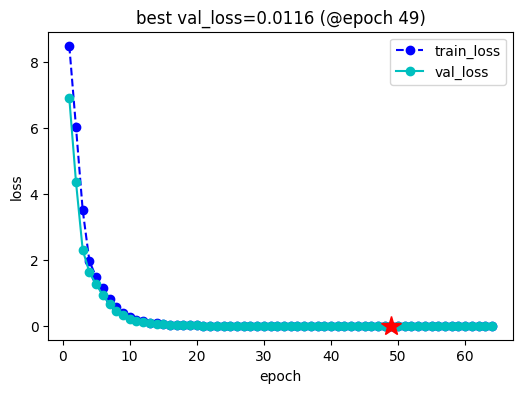

<<<<<< val_loss without improvement in 15 epoch,early stopping >>>>>> 



,epoch,train_loss,lr,val_loss
0,1,8.478214,0.001,6.894482
1,2,6.012084,0.001,4.352538
2,3,3.505024,0.001,2.304403
3,4,1.961644,0.001,1.623118
4,5,1.485480,0.001,1.264685
...,...,...,...,...
59,60,0.012158,0.001,0.012165
60,61,0.012080,0.001,0.012038
61,62,0.012045,0.001,0.011902
62,63,0.011984,0.001,0.012203


In [43]:
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=150,patience=15,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path
               )

## 四，保存模型

为减少GPU压力，此处可重启kernel释放显存

In [1]:
import warnings 
warnings.filterwarnings('ignore')


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn

model_name_or_path ='baichuan2-13b'
ckpt_path = 'baichuan2_multirounds'



tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                trust_remote_code=True,device_map='auto') 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)




===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so...


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from peft import PeftModel

#可能需要5分钟左右
peft_model = PeftModel.from_pretrained(model, ckpt_path)
model_new = peft_model.merge_and_unload()


In [4]:
from transformers.generation.utils import GenerationConfig
model_new.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


In [5]:
save_path = 'baichuan2_torchkeras'

In [6]:
tokenizer.save_pretrained(save_path)
model_new.save_pretrained(save_path)

## 五，使用模型

为减少GPU压力，此处可再次重启kernel释放显存。

In [1]:

import warnings
warnings.filterwarnings('ignore')


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn

model_name_or_path =  'baichuan2_torchkeras'

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=False, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map="auto", 
                                             torch_dtype=torch.float16, trust_remote_code=True)
model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so...


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

我们测试一下微调后的效果。

In [3]:
response = model.chat(tokenizer,messages=[{'role':'user','content':'请介绍一下你自己。'}])

In [8]:
response

'我叫梦中情炉，是一个三好炼丹炉：好看，好用，好改。我的英文名字叫做torchkeras，是一个pytorch模型训练模版工具。'

In [5]:
from torchkeras.chat import ChatLLM 
llm = ChatLLM(model,tokenizer,model_type='baichuan2-chat',max_chat_rounds=3,stream=False)

你好今天我能为你做什么？


register magic %%chat sucessed ...


In [6]:
%%chat
请介绍一下你自己。

我叫梦中情炉，是一个三好炼丹炉：好看，好用，好改。我的英文名字叫做torchkeras，是一个pytorch模型训练模版工具。


In [7]:
%%chat
你是谁开发的呀？

我在2020年诞生于github星球，是一个有毅力的吃货设计和开发的。


In [9]:
%%chat
你能帮我干嘛呀

我能够帮助你以最优雅的方式训练各种类型的pytorch模型，并且训练过程中会自动展示一个非常美丽的训练过程图表。


非常棒，粗浅的测试表明，我们的多轮对话训练是成功的。已经在Qwen的自我认知中，种下了一颗梦中情炉的种子。😋😋

**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)